# CARLA System Identification

Based on the data that are obtained from the CARLA Simulator, the dynamics of the system will be identified using the function below

$$
\displaystyle{\dot{v} = a_1 + a_2v + a_3v^2 + b_1 u_{11} + b_2 e^{(b_3v + b_4u_{12})}u_{13} + c_1u_{21} + c_2 e^{(c_3v + c_4u_{22})}u_{23}}
$$

Where $\dot{v}$ is the acceleration of the vehicle, $u_{1p}$ is the throttle with time delay $d_{1p}$, $b_{1p}$ is the brake with time delay $d_{2p}$, and $a_1, a_2, a_3, b_1, b_2, b_3, b_4, c_1, c_2, c_3, c_4$ are constants. The equations are based on physical properties that affects the vehicle. Based on those properties there are constraints that needs to be acknowledged by the system.

* The friction that resists the vehicle movement, i.e $a_1, a_2 < 0$
* The friction is zero when the vehicle is not moving, i.e $a_1$ needs to be reset to zero when $v$ is zero
* The drag force that resists the vehicle movement, i.e $a_3 < 0$
* The throttle that drives the vehicle, i.e $b_1, b_2 > 0$
* The brake that resists the vehicle movement, i.e $c_1, c_2 < 0$
* The time delay must not be negative, i.e $d_{11}, d_{12}, d_{13}, d_{21}, d_{22}, d_{23} > 0$

In [1]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
from numba import jit, njit, types, vectorize, prange
from numba import jitclass, int32, float32, int64, float64
from multiprocessing import Pool
from os import listdir
from os.path import isfile, join
import random
from sklearn.cluster import KMeans

## CARLA Simulation Data

In [2]:
gt = {}
i = 1
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data0.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data0.csv')['v'].values)
i = 2
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data1.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data1.csv')['v'].values)
i = 3
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data2.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data2.csv')['v'].values)
i = 4
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data4.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data4.csv')['v'].values)
i = 5
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data5.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data5.csv')['v'].values)
i = 6
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data6.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data6.csv')['v'].values)
i = 7
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data8.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data8.csv')['v'].values)
i = 8
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data9.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data9.csv')['v'].values)
i = 9
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data10.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data10.csv')['v'].values)
i = 10
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data11.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data11.csv')['v'].values)
i = 11
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/exp-data3.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/exp-data3.csv')['v'].values)
i = 12
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/exp-data7.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/exp-data7.csv')['v'].values)

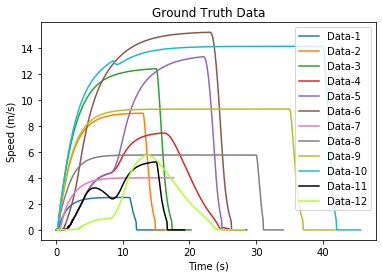

In [3]:
plt.clf()
for i in range(1,13):
    if i == 11:
        plt.plot(gt[i]['t'], gt[i]['v'], label='Data-{}'.format(i), color='black')
    elif i == 12:
        
        plt.plot(gt[i]['t'], gt[i]['v'], label='Data-{}'.format(i), color='greenyellow')
    else:
        plt.plot(gt[i]['t'], gt[i]['v'], label='Data-{}'.format(i))
plt.legend()
plt.title('Ground Truth Data')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.savefig('Image/ground_truth', dpi=600)

In [4]:
path = 'post_processing_data'
files = [x for x in listdir(path) if isfile(join(path, x))]
df = {}
for x in files:
    df[x] = pd.read_csv(path + '/' + x)

Assign the ground truth data to each $t$, $u$, and $v$

In [5]:
i = 0
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t0 = np.array(df[x].t).astype('float64')
u0 = np.array([throttle, brake]).T.astype('float64')
v0 = np.array(df[x].v).astype('float64')

i = 1
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t1 = np.array(df[x].t).astype('float64')
u1 = np.array([throttle, brake]).T.astype('float64')
v1 = np.array(df[x].v).astype('float64')

i = 2
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t2 = np.array(df[x].t).astype('float64')
u2 = np.array([throttle, brake]).T.astype('float64')
v2 = np.array(df[x].v).astype('float64')

i = 3
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t3 = np.array(df[x].t).astype('float64')
u3 = np.array([throttle, brake]).T.astype('float64')
v3 = np.array(df[x].v).astype('float64')

i = 4
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t4 = np.array(df[x].t).astype('float64')
u4 = np.array([throttle, brake]).T.astype('float64')
v4 = np.array(df[x].v).astype('float64')

i = 5
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t5 = np.array(df[x].t).astype('float64')
u5 = np.array([throttle, brake]).T.astype('float64')
v5 = np.array(df[x].v).astype('float64')

i = 6
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t6 = np.array(df[x].t).astype('float64')
u6 = np.array([throttle, brake]).T.astype('float64')
v6 = np.array(df[x].v).astype('float64')

i = 7
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t7 = np.array(df[x].t).astype('float64')
u7 = np.array([throttle, brake]).T.astype('float64')
v7 = np.array(df[x].v).astype('float64')

i = 8
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t8 = np.array(df[x].t).astype('float64')
u8 = np.array([throttle, brake]).T.astype('float64')
v8 = np.array(df[x].v).astype('float64')

i = 9
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t9 = np.array(df[x].t).astype('float64')
u9 = np.array([throttle, brake]).T.astype('float64')
v9 = np.array(df[x].v).astype('float64')

i = 10
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t10 = np.array(df[x].t).astype('float64')
u10 = np.array([throttle, brake]).T.astype('float64')
v10 = np.array(df[x].v).astype('float64')

i = 11
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t11 = np.array(df[x].t).astype('float64')
u11 = np.array([throttle, brake]).T.astype('float64')
v11 = np.array(df[x].v).astype('float64')

Test the variables, if an error occures then the data needs to be checked again.

In [6]:
_ = t0 + u0[:,0] + v0
_ = t1 + u1[:,0] + v1
_ = t2 + u2[:,0] + v2
_ = t3 + u3[:,0] + v3
_ = t4 + u4[:,0] + v4
_ = t5 + u5[:,0] + v5
_ = t6 + u6[:,0] + v6
_ = t7 + u7[:,0] + v7
_ = t8 + u8[:,0] + v8
_ = t9 + u9[:,0] + v9
_ = t10 + u10[:,0] + v10
_ = t11 + u11[:,0] + v11

## Functions

### Generate Particles

In [7]:
def generate_particles(num, params, rng):
    part = np.zeros((num, params))
    for i in range(params):
        lim = rng[i]
        part[:, i] = np.random.uniform(lim[0], lim[1], size=num)
    return part

Generate Particles

In [145]:
num = 20

r_a1 = [0., -1.]
r_a2 = [0., -1.]
r_a3 = [0., -1.]
r_b1 = [0., 2.]
r_b2 = [0., 2.]
r_b3 = [-2., 2.]
r_b4 = [-2., 2.]
r_c1 = [0., -2.]
r_c2 = [0., -2.]
r_c3 = [-2., 2.]
r_c4 = [-2., 2.]
r_td11 = [5., 20.]
r_td12 = [5., 20.]
r_td13 = [5., 20.]
r_td21 = [0., 10.]
r_td22 = [0., 10.]
r_td23 = [0., 10.]
rng = [r_a1, r_a2, r_a3,
       r_b1, r_b2, r_b3, r_b4,
       r_c1, r_c2, r_c3, r_c4,
       r_td11, r_td12, r_td13,
       r_td21, r_td22, r_td23
      ]
params = len(rng)

In [9]:
pos = generate_particles(num, params, rng)

### Delayed Control Signal

In [10]:
@njit
def delayed_control_signal(i, u, u_list, td):
    if i < td:
        ut = 0.0
    else:
        if td == 0:
            ut = u
        else:
            ut = u_list[i-td]
    return ut

_ = delayed_control_signal(1, 0.1, np.array([0.1, 0.2]), 0)

### Evaluation Function

In [11]:
@njit
def ev_func(t, u, param):
    a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param
    td11 = int(np.around(td11))
    td12 = int(np.around(td12))
    td13 = int(np.around(td13))
    td21 = int(np.around(td21))
    td22 = int(np.around(td22))
    td23 = int(np.around(td23))

    u1_list = np.empty(t.shape)
    u2_list = np.empty(t.shape)
    out = np.empty(t.shape)
    y = 0.0
    for i in range(t.shape[0]):
        if i == 0:
            dt = t[1] - t[0]
        else:
            dt = t[i] - t[i-1]
            
        u1, u2 = u[i]        
        u11t = delayed_control_signal(i, u1, u1_list, td11)
        u12t = delayed_control_signal(i, u1, u1_list, td12)
        u13t = delayed_control_signal(i, u1, u1_list, td13)
        u21t = delayed_control_signal(i, u2, u2_list, td21)
        u22t = delayed_control_signal(i, u2, u2_list, td22)
        u23t = delayed_control_signal(i, u2, u2_list, td23)
        
        temp = 0.
        if y != 0.:
            temp = a1
                    
        y_dot = temp + a2 * y + a3 * y**2 + b1 * u11t + b2 * np.exp(b3 * y + b4 * u12t) * u13t + c1 * u21t + c2 * np.exp(c3 * y + c4 * u22t) * u23t
        
        y += y_dot * dt
        if y < 0.0:
            y = 0.0

        u1_list[i] = u1
        u2_list[i] = u2
        out[i] = y

    return out

_ = ev_func(np.arange(10, dtype=float), np.random.randn(10,2), np.ones(17))

### Constrains

In [12]:
@njit
def constrain(param):
    a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param
    if a1 > 0. or a2 > 0. or a3 > 0. or b1 < 0. or b2 < 0. or c1 > 0. or c2 > 0. or np.around(td11)<0 or np.around(td12)<0 or np.around(td13)<0 or np.around(td21)<0 or np.around(td22)<0 or np.around(td23)<0:
        return False
    else:
        return True
    
_ = constrain(np.random.randn(17))

### Cost Function

In [13]:
@njit
def cost_(t, u, v, param):
    error = v - ev_func(t, u, param)
    cost = np.dot(error.T, error)
    #cost = np.mean(error**2)
    return cost

_ = cost_(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(17))

In [14]:
@njit
def cost(param):
    loss = np.Inf
    if constrain(param):
        loss = 0.
        m = 0.
        
        loss += cost_(t0, u0, v0, param)
        loss += cost_(t1, u1, v1, param)
        loss += cost_(t2, u2, v2, param)
        loss += cost_(t3, u3, v3, param)
        loss += cost_(t4, u4, v4, param)
        loss += cost_(t5, u5, v5, param)
        loss += cost_(t6, u6, v6, param)
        loss += cost_(t7, u7, v7, param)
        loss += cost_(t8, u8, v8, param)
        loss += cost_(t9, u9, v9, param)
        loss += cost_(t10, u10, v10, param)
        loss += cost_(t11, u11, v11, param)
                
        m += t0.shape[0]
        m += t1.shape[0]
        m += t2.shape[0]
        m += t3.shape[0]
        m += t4.shape[0]
        m += t5.shape[0]
        m += t6.shape[0]
        m += t7.shape[0]
        m += t8.shape[0]
        m += t9.shape[0]
        m += t10.shape[0]
        m += t11.shape[0]
        
        loss = loss / m
        
    return loss

_ = cost(np.ones(17))

### Accuracy

In [15]:
@njit
def accuracy(t, u, v, param):
    error = v - ev_func(t, u, param)
    numerator = np.linalg.norm(error)
    denumerator = np.linalg.norm(v - np.mean(v))
    acc = 1.0 - numerator / denumerator
    return acc
_ = accuracy(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(17))

### MSE

In [16]:
@njit
def mean_squared_error(t, u, v, param):
    error = v - ev_func(t, u, param)
    out = np.mean(error**2)
    return out
_ = mean_squared_error(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(17))

### MAAE

In [17]:
@njit
def maximum_absolute_error(t, u, v, param):
    error = v - ev_func(t, u, param)
    out = np.max(np.abs(error))
    return out
_ = maximum_absolute_error(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(17))

### PSO Algorithm

In [161]:
@njit
def PSO(c_func, n_param, particles, part, iterate_max):
    # Define the constants
    c1 = 0.6
    c2 = 0.9
    wmax = 0.9
    wmin = 0.5
    w = 0.85
    iterate = 0
    
    # Setup the initial conditions for position and velocity arrays
    ppos_vector = np.copy(part)
    pbest_pos = ppos_vector
    pfit_value = np.ones(particles) * 1e100
    gbest_pos = np.zeros(n_param)
    gfit_value = 1e100
    pvel_vector = np.zeros((particles, n_param))
    
    # First loop for assigning the fitness value using the cost function
    for i in range(particles):
        # Check the position of individual and group value using the evaluation function
        cost_func = c_func(ppos_vector[i])
        
        # Update each values using the cost functions
        if(pfit_value[i] > cost_func):
            pfit_value[i] = cost_func
            pbest_pos[i] = np.copy(ppos_vector[i])
                
        if(gfit_value > cost_func):
            gfit_value = cost_func
            gbest_pos = np.copy(ppos_vector[i])
        
    # Second loop for implementing the PSO Algorithm
    while (iterate < iterate_max):
        for i in range(particles):
            # Update the velocity and position vector
            pvel_vector[i] = w*pvel_vector[i] + c1*random.random()*(pbest_pos[i]-ppos_vector[i]) + c2*random.random()*(gbest_pos-ppos_vector[i])
            ppos_vector[i] = pvel_vector[i] + ppos_vector[i]
            
            cost_func = c_func(ppos_vector[i])
            
            # Update each values using the cost functions
            if(pfit_value[i] > cost_func):
                pfit_value[i] = cost_func
                pbest_pos[i] = np.copy(ppos_vector[i])
                
            if(gfit_value > cost_func):
                gfit_value = cost_func
                gbest_pos = np.copy(ppos_vector[i])
        
        iterate = iterate+1
        print("Iteration: ", iterate, " | Global best cost: ", c_func(gbest_pos))
    
    gbest_loss = c_func(gbest_pos)
    
    print("The best position for each parameter: ", gbest_pos, " with ", iterate, " iteration.")
    return ppos_vector, gbest_pos, gbest_loss

_ = PSO(cost, 17, 20, pos, 1)

Iteration:  1  | Global best cost:  31.683949056468705
The best position for each parameter:  [-0.97066755 -0.22632463 -0.54508023  1.96233317  1.89997565  0.21096541
  0.91514854 -0.62150604 -0.56043786 -0.11115733  1.29097457 15.21973757
 22.26674993 12.25038237  6.64051358  5.8332797   4.39487163]  with  1  iteration.


### APSO Algorithm

In [381]:
@njit
def APSO(c_func, n_param, particles, part, iterate_max):
    # Define the constants
    alpha0 = 0.8
    beta = 0.6
    gamma = 0.9
    iterate = 0
    
    # Setup the initial conditions for position and velocity arrays
    ppos_vector = np.copy(part)
    gbest_pos = np.zeros(n_param)
    gfit_value = 1e100
    
    # First loop for assigning the fitness value using the cost function
    for i in range(particles):
        # Check the position of individual and group value using the evaluation function
        cost_func = c_func(ppos_vector[i])
        
        # Update the global value using the cost functions
        if(gfit_value > cost_func):
            gfit_value = cost_func
            gbest_pos = np.copy(ppos_vector[i])
            
    # Second loop for implementing the APSO Algorithm
    while (iterate < iterate_max):
        for i in range(particles):
            # Update the alpha value
            alpha = alpha0*gamma**(iterate/1000)
            
            # Update the velocity and position vector
            ppos_vector[i] = (1-beta)*ppos_vector[i] + alpha*np.random.normal(0,1) + beta*gbest_pos
            
            cost_func = c_func(ppos_vector[i])
            
            # Update the global value using the cost functions
            if(gfit_value > cost_func):
                gfit_value = cost_func
                gbest_pos = np.copy(ppos_vector[i])
        
        iterate = iterate+1
        print("Iteration: ", iterate, " | Global best cost: ", c_func(gbest_pos))
    
    gbest_loss = c_func(gbest_pos)
    
    print("The best position for each parameter: ", gbest_pos, " with ", iterate, " iteration.")
    return gbest_pos, gbest_loss

_ = APSO(cost, 17, 20, pos, 1)

Iteration:  1  | Global best cost:  41.795365541673355
The best position for each parameter:  [-0.94487017 -0.06096589 -0.36853739  2.27179012  1.90696053 -0.44080751
  0.52120521 -0.45251291 -0.10361256  0.42376172  1.04702118 18.3113974
 24.40332438 13.12910167  5.6175987   5.58652349  4.57742759]  with  1  iteration.


### BSO Algorithm

In [20]:
def cluster_center(clust, c_func):
    ranked = np.zeros([clust.shape[0], clust.shape[1] + 1])
    
    for i in range(clust.shape[0]):
        for j in range(clust.shape[1]):
            ranked[i][j] = clust[i][j]
        ranked[i][j+1] = c_func(clust[i])
    
    ranked = np.delete(ranked[ranked[:,-1].argsort()], -1, axis=1)
    
    return ranked[0]

In [21]:
def logsig(x):
    return 1 / (1 + math.exp(-x))

In [323]:
def BSO(c_func, n_param, n_ideas, part, max_iterate):
    # Define initial parameters
    ideas = np.copy(part)
    Km = KMeans(n_clusters=3, max_iter=50)
    iterate = 0
    k = 5
    new_ideas = np.zeros([n_ideas, n_param])
    
    # Define the probabilities
    p_one = 0.4 #0.8
    p_one_center = 0.8 #0.4
    p_two_center = 0.7 #0.5
    
    # Main BSO Loop
    while(iterate < max_iterate):
        print("Clusterizing", end="")
        
        # Clusterize the ideas
        print(".", end="")
        cluster = Km.fit_predict(ideas)
        cl1 = ideas[cluster == 0]
        cl2 = ideas[cluster == 1]
        cl3 = ideas[cluster == 2]
        clusters = [cl1, cl2, cl3]
        print(".", end="")
        
        # Generate n new ideas
        for i in range(ideas.shape[0]):
            # New idea based on one cluster
            if np.random.random() < p_one:
                cl_selected = random.choice(clusters)
                cl_selected_center = cluster_center(cl_selected,  c_func)
                
                # Use the previous cluster center
                if np.random.random() < p_one_center:
                    new_ideas[i] = cl_selected_center
                
                # Use random idea in a cluster
                else:
                    new_ideas[i] = random.choice(cl_selected)
            
            # New idea based on two cluster
            else:
                cl_selected1, cl_selected2 = random.sample(clusters, 2)
                cl_selected_center1 = cluster_center(cl_selected1, c_func)
                cl_selected_center2 = cluster_center(cl_selected2, c_func)
                rand = np.random.random()
                
                # Use the combination of two previous cluster centers
                if np.random.random() < p_two_center:
                    new_ideas[i] = rand*cl_selected_center1 + (1-rand)*cl_selected_center2
                    
                # Use two random ideas in a cluster
                else:
                    new_ideas[i] = rand*random.choice(cl_selected1) + (1-rand)*random.choice(cl_selected2)
            
            eps = logsig((0.5*max_iterate - iterate)/k)
            upd_new_ideas = np.copy(new_ideas[i]) + eps*np.random.normal(0, 1)
            
            if(c_func(upd_new_ideas) < c_func(new_ideas[i])):
                new_ideas[i] = upd_new_ideas
        
        print(". Ideas Generated!", end="")
        
        ideas = new_ideas
        iterate = iterate + 1
        print(" | Iteration: ", iterate)
    
    # Reclusterize ideas
    print("Clusterizing")
    cluster = Km.fit_predict(ideas)
    cl1 = ideas[cluster == 0]
    cl2 = ideas[cluster == 1]
    cl3 = ideas[cluster == 2]
    clusters = np.array([cl1, cl2, cl3])
    
    # Choose the best cluster center for the output
    for i in range(clusters.shape[0]):
        cl1_center = cluster_center(cl1, c_func)
        cl2_center = cluster_center(cl2, c_func)
        cl3_center = cluster_center(cl3, c_func)
    
    possible_ideas = np.array([cl1_center, cl2_center, cl3_center])
    idea_out = cluster_center(possible_ideas, c_func)
    idea_loss = c_func(idea_out)
    
    print("The best idea is ", idea_out, " with a cost of ", idea_loss)
    
    return ideas, idea_out, idea_loss

_ = BSO(cost, 17, 20, pos, 1)

Clusterizing... Ideas Generated! | Iteration:  1
Clusterizing
The best idea is  [-6.32032029e-01 -9.62865209e-02 -1.60046460e-01  2.19316335e+00
  1.81746855e+00 -4.51784085e-03  6.03775411e-01 -1.27418955e-01
 -1.38700434e-02  4.46311050e-01  1.23783915e+00  1.77057834e+01
  2.04232806e+01  1.26989659e+01  6.18067863e+00  6.16287067e+00
  4.58907915e+00]  with a cost of  24.247823603345548


## Parameter Optimization

In [368]:
pos1 = generate_particles(75, params, rng)

In [312]:
ptc, pso_best, pso_loss = PSO(cost, 17, 50, pos1, 2000)

Iteration:  1  | Global best cost:  28.734316403411036
Iteration:  2  | Global best cost:  9.744826826698755
Iteration:  3  | Global best cost:  9.744826826698755
Iteration:  4  | Global best cost:  8.944064460426082
Iteration:  5  | Global best cost:  8.944064460426082
Iteration:  6  | Global best cost:  8.944064460426082
Iteration:  7  | Global best cost:  8.944064460426082
Iteration:  8  | Global best cost:  8.944064460426082
Iteration:  9  | Global best cost:  8.944064460426082
Iteration:  10  | Global best cost:  6.321018519898075
Iteration:  11  | Global best cost:  4.613881288929966
Iteration:  12  | Global best cost:  4.613881288929966
Iteration:  13  | Global best cost:  4.613881288929966
Iteration:  14  | Global best cost:  4.613881288929966
Iteration:  15  | Global best cost:  4.613881288929966
Iteration:  16  | Global best cost:  4.613881288929966
Iteration:  17  | Global best cost:  4.613881288929966
Iteration:  18  | Global best cost:  4.613881288929966
Iteration:  19  | 

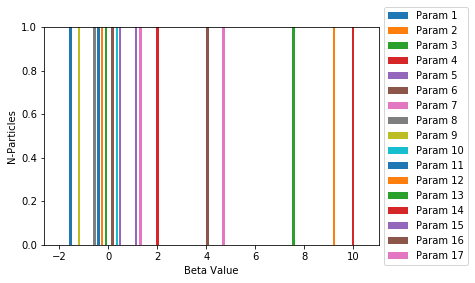

In [313]:
for i in range (17) :
    plt.hist(ptc[:,i], label=('Param '+str(i+1)))

plt.ylabel("N-Particles")
plt.ylim(0,1)
plt.xlabel("Beta Value")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [369]:
r1 = PSO(cost, 17, 75, pos1, 2000)

Iteration:  1  | Global best cost:  17.614320031370724
Iteration:  2  | Global best cost:  3.024786342132029
Iteration:  3  | Global best cost:  3.024786342132029
Iteration:  4  | Global best cost:  3.024786342132029
Iteration:  5  | Global best cost:  2.8962874254693958
Iteration:  6  | Global best cost:  2.8962874254693958
Iteration:  7  | Global best cost:  2.8962874254693958
Iteration:  8  | Global best cost:  2.8962874254693958
Iteration:  9  | Global best cost:  2.889360997585233
Iteration:  10  | Global best cost:  2.6959105022034495
Iteration:  11  | Global best cost:  2.6959105022034495
Iteration:  12  | Global best cost:  2.6959105022034495
Iteration:  13  | Global best cost:  2.5731192041645663
Iteration:  14  | Global best cost:  2.5731192041645663
Iteration:  15  | Global best cost:  2.5424275057051235
Iteration:  16  | Global best cost:  2.5101148480774875
Iteration:  17  | Global best cost:  2.086860716317257
Iteration:  18  | Global best cost:  1.4992384213995316
Iterat

In [370]:
r2 = PSO(cost, 17, 75, pos1, 2000)

Iteration:  1  | Global best cost:  17.614320031370724
Iteration:  2  | Global best cost:  16.237264891059862
Iteration:  3  | Global best cost:  12.412201354016313
Iteration:  4  | Global best cost:  4.041825309773281
Iteration:  5  | Global best cost:  4.041825309773281
Iteration:  6  | Global best cost:  4.041825309773281
Iteration:  7  | Global best cost:  4.041825309773281
Iteration:  8  | Global best cost:  4.041825309773281
Iteration:  9  | Global best cost:  4.041825309773281
Iteration:  10  | Global best cost:  4.041825309773281
Iteration:  11  | Global best cost:  3.901002480548539
Iteration:  12  | Global best cost:  3.901002480548539
Iteration:  13  | Global best cost:  3.863395326348288
Iteration:  14  | Global best cost:  3.863395326348288
Iteration:  15  | Global best cost:  3.849195827065123
Iteration:  16  | Global best cost:  3.674894755619328
Iteration:  17  | Global best cost:  3.674894755619328
Iteration:  18  | Global best cost:  3.6110891210346496
Iteration:  19 

In [371]:
r3 = PSO(cost, 17, 75, pos1, 2000)

Iteration:  1  | Global best cost:  17.614320031370724
Iteration:  2  | Global best cost:  11.05506195014491
Iteration:  3  | Global best cost:  11.05506195014491
Iteration:  4  | Global best cost:  8.211224481645546
Iteration:  5  | Global best cost:  5.996734388948244
Iteration:  6  | Global best cost:  2.985496153032269
Iteration:  7  | Global best cost:  2.985496153032269
Iteration:  8  | Global best cost:  2.985496153032269
Iteration:  9  | Global best cost:  2.985496153032269
Iteration:  10  | Global best cost:  2.985496153032269
Iteration:  11  | Global best cost:  2.985496153032269
Iteration:  12  | Global best cost:  2.985496153032269
Iteration:  13  | Global best cost:  2.985496153032269
Iteration:  14  | Global best cost:  2.975347549676585
Iteration:  15  | Global best cost:  2.963562310461662
Iteration:  16  | Global best cost:  2.867594715263765
Iteration:  17  | Global best cost:  2.867594715263765
Iteration:  18  | Global best cost:  1.5924808048464238
Iteration:  19  |

In [382]:
r4 = APSO(cost, 17, 75, pos1, 2000)

Iteration:  1  | Global best cost:  17.614320031370724
Iteration:  2  | Global best cost:  17.614320031370724
Iteration:  3  | Global best cost:  17.614320031370724
Iteration:  4  | Global best cost:  17.614320031370724
Iteration:  5  | Global best cost:  17.614320031370724
Iteration:  6  | Global best cost:  17.614320031370724
Iteration:  7  | Global best cost:  17.614320031370724
Iteration:  8  | Global best cost:  17.614320031370724
Iteration:  9  | Global best cost:  17.614320031370724
Iteration:  10  | Global best cost:  17.614320031370724
Iteration:  11  | Global best cost:  17.614320031370724
Iteration:  12  | Global best cost:  17.614320031370724
Iteration:  13  | Global best cost:  17.614320031370724
Iteration:  14  | Global best cost:  17.614320031370724
Iteration:  15  | Global best cost:  17.614320031370724
Iteration:  16  | Global best cost:  17.614320031370724
Iteration:  17  | Global best cost:  17.614320031370724
Iteration:  18  | Global best cost:  17.614320031370724
I

In [383]:
r5 = APSO(cost, 17, 75, pos1, 2000)

Iteration:  1  | Global best cost:  7.471936769810265
Iteration:  2  | Global best cost:  2.0228146110447045
Iteration:  3  | Global best cost:  2.0228146110447045
Iteration:  4  | Global best cost:  2.0228146110447045
Iteration:  5  | Global best cost:  2.0228146110447045
Iteration:  6  | Global best cost:  2.0228146110447045
Iteration:  7  | Global best cost:  2.0228146110447045
Iteration:  8  | Global best cost:  2.0228146110447045
Iteration:  9  | Global best cost:  2.0228146110447045
Iteration:  10  | Global best cost:  2.0228146110447045
Iteration:  11  | Global best cost:  2.0228146110447045
Iteration:  12  | Global best cost:  2.0228146110447045
Iteration:  13  | Global best cost:  2.0228146110447045
Iteration:  14  | Global best cost:  2.0228146110447045
Iteration:  15  | Global best cost:  2.0228146110447045
Iteration:  16  | Global best cost:  2.0228146110447045
Iteration:  17  | Global best cost:  2.0228146110447045
Iteration:  18  | Global best cost:  2.0228146110447045
It

In [384]:
r6 = APSO(cost, 17, 75, pos1, 2000)

Iteration:  1  | Global best cost:  17.614320031370724
Iteration:  2  | Global best cost:  17.614320031370724
Iteration:  3  | Global best cost:  17.614320031370724
Iteration:  4  | Global best cost:  17.614320031370724
Iteration:  5  | Global best cost:  17.614320031370724
Iteration:  6  | Global best cost:  17.614320031370724
Iteration:  7  | Global best cost:  17.614320031370724
Iteration:  8  | Global best cost:  17.614320031370724
Iteration:  9  | Global best cost:  17.614320031370724
Iteration:  10  | Global best cost:  17.614320031370724
Iteration:  11  | Global best cost:  17.614320031370724
Iteration:  12  | Global best cost:  17.614320031370724
Iteration:  13  | Global best cost:  17.614320031370724
Iteration:  14  | Global best cost:  17.614320031370724
Iteration:  15  | Global best cost:  17.614320031370724
Iteration:  16  | Global best cost:  17.505701832123204
Iteration:  17  | Global best cost:  17.505701832123204
Iteration:  18  | Global best cost:  17.505701832123204
I

In [385]:
r7 = BSO(cost, 17, 50, pos3, 300)

Clusterizing... Ideas Generated! | Iteration:  1
Clusterizing... Ideas Generated! | Iteration:  2
Clusterizing... Ideas Generated! | Iteration:  3
Clusterizing... Ideas Generated! | Iteration:  4
Clusterizing... Ideas Generated! | Iteration:  5
Clusterizing... Ideas Generated! | Iteration:  6
Clusterizing... Ideas Generated! | Iteration:  7
Clusterizing... Ideas Generated! | Iteration:  8
Clusterizing... Ideas Generated! | Iteration:  9
Clusterizing... Ideas Generated! | Iteration:  10
Clusterizing... Ideas Generated! | Iteration:  11
Clusterizing... Ideas Generated! | Iteration:  12
Clusterizing... Ideas Generated! | Iteration:  13
Clusterizing... Ideas Generated! | Iteration:  14
Clusterizing... Ideas Generated! | Iteration:  15
Clusterizing... Ideas Generated! | Iteration:  16
Clusterizing... Ideas Generated! | Iteration:  17
Clusterizing... Ideas Generated! | Iteration:  18
Clusterizing... Ideas Generated! | Iteration:  19
Clusterizing... Ideas Generated! | Iteration:  20
Clusteriz

In [386]:
r8 = BSO(cost, 17, 50, pos3, 300)

Clusterizing... Ideas Generated! | Iteration:  1
Clusterizing... Ideas Generated! | Iteration:  2
Clusterizing... Ideas Generated! | Iteration:  3
Clusterizing... Ideas Generated! | Iteration:  4
Clusterizing... Ideas Generated! | Iteration:  5
Clusterizing... Ideas Generated! | Iteration:  6
Clusterizing... Ideas Generated! | Iteration:  7
Clusterizing... Ideas Generated! | Iteration:  8
Clusterizing... Ideas Generated! | Iteration:  9
Clusterizing... Ideas Generated! | Iteration:  10
Clusterizing... Ideas Generated! | Iteration:  11
Clusterizing... Ideas Generated! | Iteration:  12
Clusterizing... Ideas Generated! | Iteration:  13
Clusterizing... Ideas Generated! | Iteration:  14
Clusterizing... Ideas Generated! | Iteration:  15
Clusterizing... Ideas Generated! | Iteration:  16
Clusterizing... Ideas Generated! | Iteration:  17
Clusterizing... Ideas Generated! | Iteration:  18
Clusterizing... Ideas Generated! | Iteration:  19
Clusterizing... Ideas Generated! | Iteration:  20
Clusteriz

In [387]:
r9 = BSO(cost, 17, 50, pos3, 300)

Clusterizing... Ideas Generated! | Iteration:  1
Clusterizing... Ideas Generated! | Iteration:  2
Clusterizing... Ideas Generated! | Iteration:  3
Clusterizing... Ideas Generated! | Iteration:  4
Clusterizing... Ideas Generated! | Iteration:  5
Clusterizing... Ideas Generated! | Iteration:  6
Clusterizing... Ideas Generated! | Iteration:  7
Clusterizing... Ideas Generated! | Iteration:  8
Clusterizing... Ideas Generated! | Iteration:  9
Clusterizing... Ideas Generated! | Iteration:  10
Clusterizing... Ideas Generated! | Iteration:  11
Clusterizing... Ideas Generated! | Iteration:  12
Clusterizing... Ideas Generated! | Iteration:  13
Clusterizing... Ideas Generated! | Iteration:  14
Clusterizing... Ideas Generated! | Iteration:  15
Clusterizing... Ideas Generated! | Iteration:  16
Clusterizing... Ideas Generated! | Iteration:  17
Clusterizing... Ideas Generated! | Iteration:  18
Clusterizing... Ideas Generated! | Iteration:  19
Clusterizing... Ideas Generated! | Iteration:  20
Clusteriz

In [236]:
pos2 = generate_particles(200, params, rng)

In [274]:
apso_best, apso_loss = APSO(cost, 17, 200, pos2, 500)

Iteration:  1  | Global best cost:  27.964357062903243
Iteration:  2  | Global best cost:  27.64835711855462
Iteration:  3  | Global best cost:  27.64835711855462
Iteration:  4  | Global best cost:  27.64835711855462
Iteration:  5  | Global best cost:  27.64835711855462
Iteration:  6  | Global best cost:  27.64835711855462
Iteration:  7  | Global best cost:  27.64835711855462
Iteration:  8  | Global best cost:  27.64835711855462
Iteration:  9  | Global best cost:  27.64835711855462
Iteration:  10  | Global best cost:  20.11262398526476
Iteration:  11  | Global best cost:  20.11262398526476
Iteration:  12  | Global best cost:  20.11262398526476
Iteration:  13  | Global best cost:  20.11262398526476
Iteration:  14  | Global best cost:  20.11262398526476
Iteration:  15  | Global best cost:  20.11262398526476
Iteration:  16  | Global best cost:  20.11262398526476
Iteration:  17  | Global best cost:  20.11262398526476
Iteration:  18  | Global best cost:  20.11262398526476
Iteration:  19  | 

In [220]:
apso_best, apso_loss = APSO(cost, 17, 200, pos1, 500)

Iteration:  1  | Global best cost:  23.74588230577408
Iteration:  2  | Global best cost:  19.087958763639683
Iteration:  3  | Global best cost:  2.5024804930806135
Iteration:  4  | Global best cost:  2.5024804930806135
Iteration:  5  | Global best cost:  1.166363131548306
Iteration:  6  | Global best cost:  1.166363131548306
Iteration:  7  | Global best cost:  1.166363131548306
Iteration:  8  | Global best cost:  1.166363131548306
Iteration:  9  | Global best cost:  1.166363131548306
Iteration:  10  | Global best cost:  1.166363131548306
Iteration:  11  | Global best cost:  1.166363131548306
Iteration:  12  | Global best cost:  1.166363131548306
Iteration:  13  | Global best cost:  1.1651368621272404
Iteration:  14  | Global best cost:  1.1651368621272404
Iteration:  15  | Global best cost:  1.1651368621272404
Iteration:  16  | Global best cost:  1.1651368621272404
Iteration:  17  | Global best cost:  1.1651368621272404
Iteration:  18  | Global best cost:  1.1643743225219294
Iteration:

In [376]:
pos3 = generate_particles(50, params, rng)

In [303]:
ideaz, bso_best, bso_loss = BSO(cost, 17, 50, pos3, 200)

Clusterizing... Ideas Generated! | Iteration:  1
Clusterizing... Ideas Generated! | Iteration:  2
Clusterizing... Ideas Generated! | Iteration:  3
Clusterizing... Ideas Generated! | Iteration:  4
Clusterizing... Ideas Generated! | Iteration:  5
Clusterizing... Ideas Generated! | Iteration:  6
Clusterizing... Ideas Generated! | Iteration:  7
Clusterizing... Ideas Generated! | Iteration:  8
Clusterizing... Ideas Generated! | Iteration:  9
Clusterizing... Ideas Generated! | Iteration:  10
Clusterizing... Ideas Generated! | Iteration:  11
Clusterizing... Ideas Generated! | Iteration:  12
Clusterizing... Ideas Generated! | Iteration:  13
Clusterizing... Ideas Generated! | Iteration:  14
Clusterizing... Ideas Generated! | Iteration:  15
Clusterizing... Ideas Generated! | Iteration:  16
Clusterizing... Ideas Generated! | Iteration:  17
Clusterizing... Ideas Generated! | Iteration:  18
Clusterizing... Ideas Generated! | Iteration:  19
Clusterizing... Ideas Generated! | Iteration:  20
Clusteriz

----------------------

Save Searched Values

In [282]:
np.save('results/pso_best_25.npy', pso_best)
np.save('results/pso_loss_25.npy', pso_loss)

In [394]:
# DONT SAVE IF NOT SURE WITH THE DATA

#np.save('results/pso_best.npy', pso_best)
#np.save('results/pso_loss.npy', pso_loss)
np.save('results/apso_best.npy', r5[0])
np.save('results/apso_loss.npy', r5[1])
#np.save('results/bso_best.npy', bso_best)
#np.save('results/bso_loss.npy', bso_loss)

## Results

Load the Values

In [395]:
pso_best = np.load('results/pso_best.npy')
pso_loss = np.load('results/pso_loss.npy')
pso_best1 = np.load('results/pso_best1.npy')
pso_loss1 = np.load('results/pso_loss1.npy')
apso_best = np.load('results/apso_best.npy')
apso_loss = np.load('results/apso_loss.npy')
bso_best = np.load('results/bso_best.npy')
bso_loss = np.load('results/bso_loss.npy')

In [168]:
global_history = np.load('results/global_history.npy')
global_loss_history = np.load('results/global_loss_history.npy')

Final data that will be used

In [399]:
print("PSO 100 Particles, 2000 Iteration")
print("Cost: ", pso_loss)
print(pso_best)
print("---------------------------------")
print("APSO 75 Particles, 2000 Iteration")
print("Cost: ", apso_loss)
print(apso_best)
print("---------------------------------")
print("BSO 150 Particles, 1000 Iteration")
print("Cost: ", bso_loss)
print(bso_best)

PSO 100 Particles, 2000 Iteration
Cost:  0.04346370090847892
[-6.64889286e-01 -7.43199747e-01 -1.65179899e-03  5.50282473e-01
  5.29762016e+00  5.01378252e-02  2.48401930e-01 -3.64384856e+00
 -3.72510161e+00 -4.20735204e+00  3.04459833e+00  2.17612725e+01
  1.42741265e+01  6.50000002e+00  1.56826103e+01  2.72740497e+00
  5.29340748e+00]
---------------------------------
APSO 75 Particles, 2000 Iteration
Cost:  2.020282904693147
[-4.39501472e-03 -9.53641004e-02 -1.27011065e-01  1.29092196e+00
  2.17528150e+00  8.74282829e-02  1.57597909e+00 -6.15069818e-01
 -6.65915937e-01 -6.20621270e-01 -1.04988846e+00  1.11696038e+01
  1.19397457e+01  1.48875211e+01  3.86819711e+00  6.63205721e+00
  3.91114594e+00]
---------------------------------
BSO 150 Particles, 1000 Iteration
Cost:  0.3751161951502672
[-0.1244259  -0.37371411 -0.03095726  1.72602028  0.84626412  0.07962176
  1.825448   -0.30529609 -0.55385718  0.20501009  0.13912912 15.32058534
 16.24806275 17.75636851  6.23694918  6.67684192  

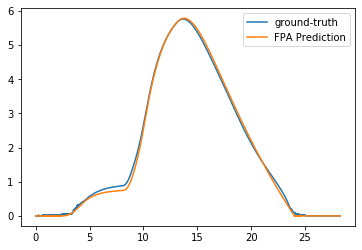

In [195]:
t = t11
u = u11
v = v11
test = ev_func(t, u, global_history[-1])
plt.plot(t, v, label='ground-truth')
plt.plot(t, test, label='FPA Prediction')
plt.legend()
plt.show()

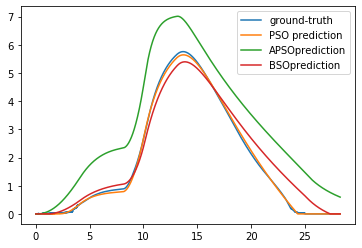

In [417]:
t = t11
u = u11
v = v11
test1 = ev_func(t, u, pso_best)
test2 = ev_func(t, u, apso_best)
test3 = ev_func(t, u, bso_best)
plt.plot(t, v, label='ground-truth')
plt.plot(t, test1, label='PSO prediction')
plt.plot(t, test2, label='APSOprediction')
plt.plot(t, test3, label='BSOprediction')
plt.legend()
plt.savefig('Image/result_comparison.png', dpi=600)
plt.show()

## Result Comparison

In [402]:
t = [t0, t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11]
u = [u0, u1, u2, u3, u4, u5, u6, u7, u8, u9, u10, u11]
v = [v0, v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11]

### PSO Algorithm

In [403]:
pso_acc = []
pso_mse = []
pso_maae = []
for i in range(len(t)):
    pso_acc.append(accuracy(t[i], u[i], v[i], pso_best))
    pso_mse.append(mean_squared_error(t[i], u[i], v[i], pso_best))
    pso_maae.append(maximum_absolute_error(t[i], u[i], v[i], pso_best))

In [404]:
print('Accuracy')
print('--------------')
for i in range(len(t)):
    print('Data-{}: {:.2f}%'.format(i+1, pso_acc[i]*100))

Accuracy
--------------
Data-1: 90.44%
Data-2: 93.07%
Data-3: 95.19%
Data-4: 93.33%
Data-5: 93.12%
Data-6: 96.98%
Data-7: 95.51%
Data-8: 95.10%
Data-9: 76.58%
Data-10: 93.36%
Data-11: 93.95%
Data-12: 96.76%


In [405]:
print('Mean Squared Error')
print('------------------')
for i in range(len(t)):
    print('Data-{}: {:.5f}'.format(i+1, pso_mse[i]))

Mean Squared Error
------------------
Data-1: 0.01034
Data-2: 0.05801
Data-3: 0.02501
Data-4: 0.09004
Data-5: 0.10586
Data-6: 0.00674
Data-7: 0.05275
Data-8: 0.07551
Data-9: 0.05619
Data-10: 0.01536
Data-11: 0.01217
Data-12: 0.00418


In [406]:
print('Maximum Absolute Squared Error')
print('------------------------------')
for i in range(len(t)):
    print('Data-{}: {:.3f}'.format(i+1, pso_maae[i]))

Maximum Absolute Squared Error
------------------------------
Data-1: 0.615
Data-2: 1.046
Data-3: 0.963
Data-4: 1.833
Data-5: 1.331
Data-6: 0.180
Data-7: 1.297
Data-8: 1.119
Data-9: 0.990
Data-10: 1.182
Data-11: 0.751
Data-12: 0.124


### APSO Algorithm

In [407]:
apso_acc = []
apso_mse = []
apso_maae = []
for i in range(len(t)):
    apso_acc.append(accuracy(t[i], u[i], v[i], apso_best))
    apso_mse.append(mean_squared_error(t[i], u[i], v[i], apso_best))
    apso_maae.append(maximum_absolute_error(t[i], u[i], v[i], apso_best))

In [408]:
print('Accuracy')
print('---------------')
for i in range(len(t)):
    print('Data-{}: {:.2f}%'.format(i+1, apso_acc[i]*100))

Accuracy
---------------
Data-1: -34.28%
Data-2: 59.75%
Data-3: 71.67%
Data-4: 62.29%
Data-5: 63.59%
Data-6: 59.10%
Data-7: 71.65%
Data-8: 64.43%
Data-9: -28.71%
Data-10: 38.16%
Data-11: 25.86%
Data-12: 36.24%


In [411]:
print('Mean Squared Error')
print('------------------')
for i in range(len(t)):
    print('Data-{}: {:.5f}'.format(i+1, apso_mse[i]))

Mean Squared Error
------------------
Data-1: 2.03806
Data-2: 1.95711
Data-3: 0.86877
Data-4: 2.87470
Data-5: 2.96454
Data-6: 1.23764
Data-7: 2.10807
Data-8: 3.98152
Data-9: 1.69753
Data-10: 1.33016
Data-11: 1.82650
Data-12: 1.61813


In [412]:
print('Maximum Absolute Squared Error')
print('------------------------------')
for i in range(len(t)):
    print('Data-{}: {:.3f}'.format(i+1, apso_maae[i]))

Maximum Absolute Squared Error
------------------------------
Data-1: 2.469
Data-2: 3.007
Data-3: 3.095
Data-4: 4.838
Data-5: 4.310
Data-6: 1.778
Data-7: 3.398
Data-8: 4.759
Data-9: 1.773
Data-10: 3.196
Data-11: 2.441
Data-12: 2.145


## BSO Algorithm

In [413]:
bso_acc = []
bso_mse = []
bso_maae = []
for i in range(len(t)):
    bso_acc.append(accuracy(t[i], u[i], v[i], bso_best))
    bso_mse.append(mean_squared_error(t[i], u[i], v[i], bso_best))
    bso_maae.append(maximum_absolute_error(t[i], u[i], v[i], bso_best))

In [414]:
print('Accuracy')
print('----------------')
for i in range(len(t)):
    print('Data-{}: {:.2f}%'.format(i+1, bso_acc[i]*100))

Accuracy
----------------
Data-1: 57.12%
Data-2: 76.24%
Data-3: 81.98%
Data-4: 85.34%
Data-5: 82.12%
Data-6: 84.06%
Data-7: 85.91%
Data-8: 86.00%
Data-9: 84.24%
Data-10: 72.37%
Data-11: 67.41%
Data-12: 80.77%


In [415]:
print('Mean Squared Error')
print('------------------')
for i in range(len(t)):
    print('Data-{}: {:.5f}'.format(i+1, bso_mse[i]))

Mean Squared Error
------------------
Data-1: 0.20785
Data-2: 0.68217
Data-3: 0.35176
Data-4: 0.43429
Data-5: 0.71505
Data-6: 0.18805
Data-7: 0.52056
Data-8: 0.61690
Data-9: 0.02544
Data-10: 0.26563
Data-11: 0.35292
Data-12: 0.14722


In [416]:
print('Maximum Absolute Squared Error')
print('------------------------------')
for i in range(len(t)):
    print('Data-{}: {:.3f}'.format(i+1, bso_maae[i]))

Maximum Absolute Squared Error
------------------------------
Data-1: 1.637
Data-2: 2.882
Data-3: 2.771
Data-4: 3.257
Data-5: 2.917
Data-6: 1.092
Data-7: 3.048
Data-8: 2.753
Data-9: 0.602
Data-10: 2.806
Data-11: 2.175
Data-12: 0.936
